**Group members**:\
Antonella Buccione - 3015999\
Jacopo Bugini - 3027525\
Andrea Maccarrone - 3013402\
Sebastiano Moro - 3017824

# Gold standard

A system with no differences between men and women.\
The  objective  is  to  understand  how  to  generate  a stable  market  over  time and  provide  a  ”gold  standard”  system  to  strive  towards.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
from mesa.space import MultiGrid
import numpy as np
import pandas as pd
import seaborn as sns
from mesa.datacollection import DataCollector
import matplotlib.ticker as mtick
np.random.seed(22)

## Agent class

In [2]:
class Worker(Agent):
    '''
    gender: M or F
    level: 0 unemployed, 1 employee, 2 manager, 3 director
    education: a value from standard normal distribution centered in 2.5
    age: tends to replicate the current job market age distribution
    skills: innate abilities of the agents randomly assigned
    level_tenure: time spent in the current level
    total_tenure: total working years
    trials: it counts the years of unsuccessful applications until the agent finally becomes employed
    aspiration: self-perceived value of the agent
    value: employer-perceived value of the agent
    '''
    def __init__(self, unique_id, model, level=0, age=23, education=max(np.random.randn(1)[0]+2.5,0),total_tenure=0):
        super().__init__(unique_id, model)
        self.gender = np.random.choice(['M','F'], p=([1/2]*2))
        self.level = level
        self.education = education
        self.age = age
        self.skills = np.random.randn(1)[0]*1.5
        self.level_tenure = 0
        self.total_tenure = total_tenure
        self.trials = 0
        self.aspiration = 0
        self.value = 0
    
    def update(self):
        # age
        self.age+=1/12
        
        # trials
        if self.level==0 and self.trials<4:
            self.trials+=1/12
        if self.trials>=4:
            return
        
        # tenure update
        if self.level>0:
            self.total_tenure+=1/12
            self.level_tenure+=1/12 
        
        # aspiration & value
        self.aspiration = 3*(self.level+1)*(self.education) + np.log(self.level_tenure+1)/2 - self.trials           
        self.value = 3*(self.level+1)*(self.education + self.skills) + np.log(self.level_tenure+1)/2 - max(0, (self.age-40))
    
    def change_aspiration(self):
        # once a year the agents interact with their neighbors and adjust their aspiration 
        if np.random.rand()<1/12:
            neighbors = [neighbor for neighbor in self.model.grid.neighbor_iter(self.pos) if neighbor.aspiration >= self.aspiration]
            self.tot_neig = len(list(neighbors))
            if self.tot_neig > 0:
                average_aspiration=np.mean([neighbor.aspiration for neighbor in self.model.grid.neighbor_iter(self.pos)  if neighbor.aspiration >= self.aspiration])
                self.aspiration= self.aspiration*self.model.alpha + average_aspiration*(1-self.model.alpha)
    
    def training(self):
        # these are courses/online training that agents undertake to improve their education (almost once every two years)
        if np.random.rand()<(1/24) and self.age<35:
            self.education*=max(1.01,np.random.randn(1)[0]*0.2+1)
        
    def seek_job(self):
        # agents check if there are open positions that match their aspiration in relation with their current status
        if self.trials>=4:
            return
        possible_jobs=[j for j in self.model.jobschedule.agents]
        desired_jobs=[job for job in possible_jobs if job.level==self.level+1 \
                      and self.level_tenure >= job.tenure_required \
                      and self.education >= job.education_required \
                      and self.aspiration*0.75<=job.wage \
                      and self.aspiration*1.25>=job.wage]
        if len(desired_jobs)>0:
            other_agent = self.random.choice(desired_jobs)
            other_agent.candidates.append(self)
        
    def step(self):
        self.update()
        self.change_aspiration()
        self.training()
        self.seek_job()

## Job Offer

In [3]:
class JobOffer(Agent):
    '''
    level: level of the offered position
    education_required: minimun level of education required by the job
    tenure_required: years of experience required in the previous position job
    ranking: intrinsic value of the position defined as a normal random variable 
    wage: value of the position perceived by the agents 
    candidates: list of the agents that applied for the job
    '''
    def __init__(self, unique_id, model,p=[0.73/0.9,0.12/0.9,0.05/0.9]):
        super().__init__(unique_id, model)
        self.level=np.random.choice([i+1 for i in range(3)], p=p)
        self.candidates=[]
        
        # education required for the job
        if self.level==1:
            self.education_required=np.random.choice([2,3], p=[0.2,0.8])
        elif self.level == 2:
            self.education_required=np.random.choice([3,4], p=[0.3,0.7])
        elif self.level == 3:
            self.education_required=np.random.choice([4,5], p=[0.5,0.5])
        
        # ranking  
        self.ranking = np.random.randn(1)[0]*1.5
        
        # years of tenure required in the previous position
        self.tenure_required=0
        if self.level == 2:
            self.tenure_required=12
        elif self.level == 3:
            self.tenure_required=10
        
        # wage
        self.wage = 3*self.level * (self.education_required + self.ranking) +  np.log(self.tenure_required+1)/2
            
    def choose_candidate(self):
        # the job is assigned to the candidate with the highest value
        if len(self.candidates)>0:
            best_candidate=self.candidates[0]
            for cand in self.candidates:
                if cand.value>best_candidate.value:
                    best_candidate=cand
            best_candidate.level+=1
            best_candidate.level_tenure=0
    
    def step(self):
        self.choose_candidate()

## Labour market

Functions for the datacollector

In [4]:
def average_aspiration_M(model):
    return np.mean([agent.aspiration for agent in model.schedule.agents if agent.gender=='M'])

def average_aspiration_F(model):
    return np.mean([agent.aspiration for agent in model.schedule.agents if agent.gender=='F'])

def average_level_M(model):
    return np.mean([agent.level for agent in model.schedule.agents if agent.gender=='M'])

def average_level_F(model):
    return np.mean([agent.level for agent in model.schedule.agents if agent.gender=='F'])

def average_agents_M(model):
    return sum([1/model.num_agents for agent in model.schedule.agents if agent.gender=='M'])

def average_agents_F(model):
    return sum([1/model.num_agents for agent in model.schedule.agents if agent.gender=='F'])

def average_tenure_M(model):
    return np.mean([agent.level_tenure for agent in model.schedule.agents if agent.gender=='M'])

def average_tenure_F(model):
    return np.mean([agent.level_tenure for agent in model.schedule.agents if agent.gender=='F'])

def average_age_F(model):
    return np.mean([agent.age for agent in model.schedule.agents if agent.gender=='F'])

def average_age_M(model):
    return np.mean([agent.age for agent in model.schedule.agents if agent.gender=='M'])

def average_skills_F(model):
    return np.mean([agent.skills for agent in model.schedule.agents if agent.gender=='F'])

def average_skills_M(model):
    return np.mean([agent.skills for agent in model.schedule.agents if agent.gender=='M'])

def average_value(model):
    return np.mean([agent.value for agent in model.schedule.agents])

def average_value_F(model):
    return np.mean([agent.value for agent in model.schedule.agents if agent.gender == 'F'])

def average_value_M(model):
    return np.mean([agent.value for agent in model.schedule.agents if agent.gender == 'M'])

def male_level_distribution(model):
    tot=sum([1 for agent in model.schedule.agents if agent.gender=='M'])
    return {i:sum([1/tot for agent in model.schedule.agents if agent.gender=='M' and agent.level==i]) for i in range(4)}

def female_level_distribution(model):
    tot=sum([1 for agent in model.schedule.agents if agent.gender=='F'])
    return {i:sum([1/tot for agent in model.schedule.agents if agent.gender=='F' and agent.level==i]) for i in range(4)}

def male_skill_distribution(model):
    return {i:np.mean([agent.skills for agent in model.schedule.agents if agent.gender=='M' and agent.level==i]) for i in range(4)}

def female_skill_distribution(model):
    return {i:np.mean([agent.skills for agent in model.schedule.agents if agent.gender=='F' and agent.level==i]) for i in range(4)}

def male_value_distribution(model):
    return {i:np.mean([agent.value for agent in model.schedule.agents if agent.gender=='M' and agent.level==i]) for i in range(4)}

def female_value_distribution(model):
    return {i:np.mean([agent.value for agent in model.schedule.agents if agent.gender=='F' and agent.level==i]) for i in range(4)}

In [5]:
class LabourMarket(Model):
    '''
    num_agents: number of agents in the model
    total_agents_count: number of all the agents that entered in the model
    gap_perceived: measure of the gender gap based on the average levels per gender
    alpha: level of self-confidence of the agents
    p_initial: level distribution of the starting dummy agents
    num_jobs: number of job offers at each iteration
    '''
    def __init__(self, N, width, height, M=0.4):
        self.num_agents = N
        self.total_agents_count = N
        self.gap_perceived=0
        self.alpha=0.6
        self.p_initial=[0.1,0.73,0.12,0.05] 
        self.num_jobs=int(N*M)
        self.grid = MultiGrid(width, height, True)
        self.schedule=RandomActivation(self)
        
        # create agents
        for i in range(self.num_agents):
            level = np.random.choice([0, 1, 2, 3], p=self.p_initial)
            education = max(0,np.random.randn(1)[0]+level+1)
            age = max(23,np.random.randn(1)[0]*12+44) 
            total_tenure=max(0,np.random.randn(1)[0]*10+25)
            
            a = Worker(i, self, level, age, education,total_tenure)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
        model_reporters={'aspiration_M': average_aspiration_M,'aspiration_F': average_aspiration_F,
                         'level_M': average_level_M,'level_F': average_level_F,
                         'agents_M': average_agents_M,'agents_F': average_agents_F,
                         'tenure_M': average_tenure_M,'tenure_F': average_tenure_F,
                         'age_M': average_age_M,'age_F': average_age_F,
                         'skills_M': average_skills_M,'skills_F': average_skills_F,
                         'average_value':average_value,
                         'average_value_M':average_value_M,'average_value_F':average_value_F,
                         'male_level_distribution': male_level_distribution,
                         'female_level_distribution': female_level_distribution,
                         'male_skill_distribution': male_skill_distribution,
                         'female_skill_distribution': female_skill_distribution,
                         'male_value_distribution': male_value_distribution,
                         'female_value_distribution': female_value_distribution})   
        
    def add_agents(self):
        # to maintain constant the number of the agent in the environment 
        new_entry = len([agent for agent in model.schedule.agents if agent.trials >= 4 \
                    or (agent.total_tenure + agent.age) >= 100 \
                    or agent.age > 60 \
                    or agent.total_tenure > 40])
        
        if new_entry > 0:        
            for i in range(new_entry):
                self.total_agents_count+=1
                a = Worker(self.total_agents_count, self)
                self.schedule.add(a)

                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                self.grid.place_agent(a, (x, y))
                self.num_agents+=1

    def remove_agents(self):
        # agents retired for age or for working years or a mixture of the two
        old_agents=[agent for agent in model.schedule.agents if agent.trials >= 4 \
                    or (agent.total_tenure + agent.age) >= 100 \
                    or agent.age > 60 \
                    or agent.total_tenure > 40]
        
        if len(old_agents) > 0:
            for i in old_agents:
                self.schedule.remove(i)
                self.num_agents-=1         
            
            
    def step(self):
        self.add_agents()
        self.remove_agents()
        # new jobs ae created at every iteration
        self.jobschedule = RandomActivation(self)
        for i in range(self.num_jobs):
            j = JobOffer(i, self)
            self.jobschedule.add(j)
        self.schedule.step()
        self.jobschedule.step()
        self.datacollector.collect(self)

## Batchrunner

Given the fact that agents leave the model and our measure are related only to agents that are in the model, we implemented an ad-hoc solution to simulate the same batchrunner function.

In [6]:
iter=100
master=pd.DataFrame(columns={'Datacollector'},index=range(iter))
for j in range(iter):
    model = LabourMarket(300, 20, 20,0.01)
    for i in range(1200):
        model.step()
        master['Datacollector'][j]=model.datacollector.get_model_vars_dataframe()

C:\Users\acer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\acer\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
def get_levels_distribution(master,variable):
    levels=pd.DataFrame(columns={'Datacollector'},index=range(master.shape[0]))
    for i in range(master.shape[0]):
        levels['Datacollector'][i]=pd.DataFrame(list(master['Datacollector'][i][variable]))
    zeros = []
    ones= []
    twos = []
    threes= []

    for isim in range(master.shape[0]):
        zeros.append(levels['Datacollector'][isim][0])
        ones.append(levels['Datacollector'][isim][1])
        twos.append(levels['Datacollector'][isim][2])
        threes.append(levels['Datacollector'][isim][3])

    zeros_M = np.mean(zeros, axis=0)[400:]
    ones_M = np.mean(ones, axis=0)[400:]
    twos_M = np.mean(twos, axis=0)[400:]
    threes_M = np.mean(threes, axis=0)[400:]

    return zeros_M,ones_M,twos_M,threes_M

In [8]:
def get_value_distribution(master,variable):
    levels=pd.DataFrame(columns={'Datacollector'},index=range(master.shape[0]))
    for i in range(master.shape[0]):
        levels['Datacollector'][i]=pd.DataFrame(list(master['Datacollector'][i][variable]))
    zeros = []
    ones= []
    twos = []
    threes= []

    for isim in range(master.shape[0]):
        zeros.append(np.array(levels['Datacollector'][isim][0]))
        ones.append(np.array(levels['Datacollector'][isim][1]))
        twos.append(np.array(levels['Datacollector'][isim][2]))
        threes.append(np.array(levels['Datacollector'][isim][3]))
    
    zeros_M = np.nanmean(zeros, axis=0)[400:]
    ones_M = np.nanmean(ones, axis=0)[400:]
    twos_M = np.nanmean(twos, axis=0)[400:]
    threes_M = np.nanmean(threes, axis=0)[400:]
    
    std_zeros_M = np.nanstd(zeros, axis=0, dtype=np.float64)[400:]
    std_ones_M = np.nanstd(ones, axis=0, dtype=np.float64)[400:]
    std_twos_M = np.nanstd(twos, axis=0, dtype=np.float64)[400:]
    std_threes_M = np.nanstd(threes, axis=0, dtype=np.float64)[400:]

    return zeros_M,ones_M,twos_M,threes_M,std_zeros_M,std_ones_M ,std_twos_M ,std_threes_M 

In [9]:
aspiration_M = []
aspiration_F= []
level_M = []
level_F= []
age_M = []
age_F= []
agents_M=[]
agents_F=[]
skills_M = []
skills_F= []
value=[]
value_M=[]
value_F=[]

for isim in range(master.shape[0]):
    aspiration_M.append(master['Datacollector'][isim].aspiration_M)
    aspiration_F.append(master['Datacollector'][isim].aspiration_F)
    level_M.append(master['Datacollector'][isim].level_M)
    level_F.append(master['Datacollector'][isim].level_F)
    age_M.append(master['Datacollector'][isim].age_M)
    age_F.append(master['Datacollector'][isim].age_F)
    agents_M.append(master['Datacollector'][isim].agents_M)
    agents_F.append(master['Datacollector'][isim].agents_F)
    skills_M.append(master['Datacollector'][isim].skills_M)
    skills_F.append(master['Datacollector'][isim].skills_F)
    value.append(master['Datacollector'][isim].average_value)
    value_M.append(master['Datacollector'][isim].average_value_M)
    value_F.append(master['Datacollector'][isim].average_value_F)
    
mean_asp_M = np.mean(aspiration_M, axis=0)[400:]
mean_asp_F = np.mean(aspiration_F, axis=0)[400:]
mean_level_M = np.mean(level_M, axis=0)[400:]
mean_level_F = np.mean(level_F, axis=0)[400:]
mean_age_M = np.mean(age_M, axis=0)[400:]
mean_age_F = np.mean(age_F, axis=0)[400:]
mean_agents_M = np.mean(agents_M, axis=0)[400:]
mean_agents_F = np.mean(agents_F, axis=0)[400:]
mean_skills_M = np.mean(skills_M, axis=0)[400:]
mean_skills_F = np.mean(skills_F, axis=0)[400:]
mean_value = np.mean(value, axis=0)[400:]
mean_value_M = np.mean(value_M, axis=0)[400:]
mean_value_F = np.mean(value_F, axis=0)[400:]

sd_asp_M = np.std(aspiration_M, axis=0, dtype=np.float64)[400:]
sd_asp_F = np.std(aspiration_F, axis=0, dtype=np.float64)[400:]
sd_level_M = np.std(level_M, axis=0, dtype=np.float64)[400:]
sd_level_F = np.std(level_F, axis=0, dtype=np.float64)[400:]
sd_age_M = np.std(age_M, axis=0, dtype=np.float64)[400:]
sd_age_F = np.std(age_F, axis=0, dtype=np.float64)[400:]
sd_agents_M = np.std(agents_M, axis=0, dtype=np.float64)[400:]
sd_agents_F = np.std(agents_F, axis=0, dtype=np.float64)[400:]
sd_skills_M = np.std(skills_M, axis=0, dtype=np.float64)[400:]
sd_skills_F = np.std(skills_F, axis=0, dtype=np.float64)[400:]
sd_value = np.std(value, axis=0, dtype=np.float64)[400:]
sd_value_M = np.std(value_M, axis=0, dtype=np.float64)[400:]
sd_value_F = np.std(value_F, axis=0, dtype=np.float64)[400:]

value_male=get_value_distribution(master,'male_value_distribution')
value_female=get_value_distribution(master,'female_value_distribution')

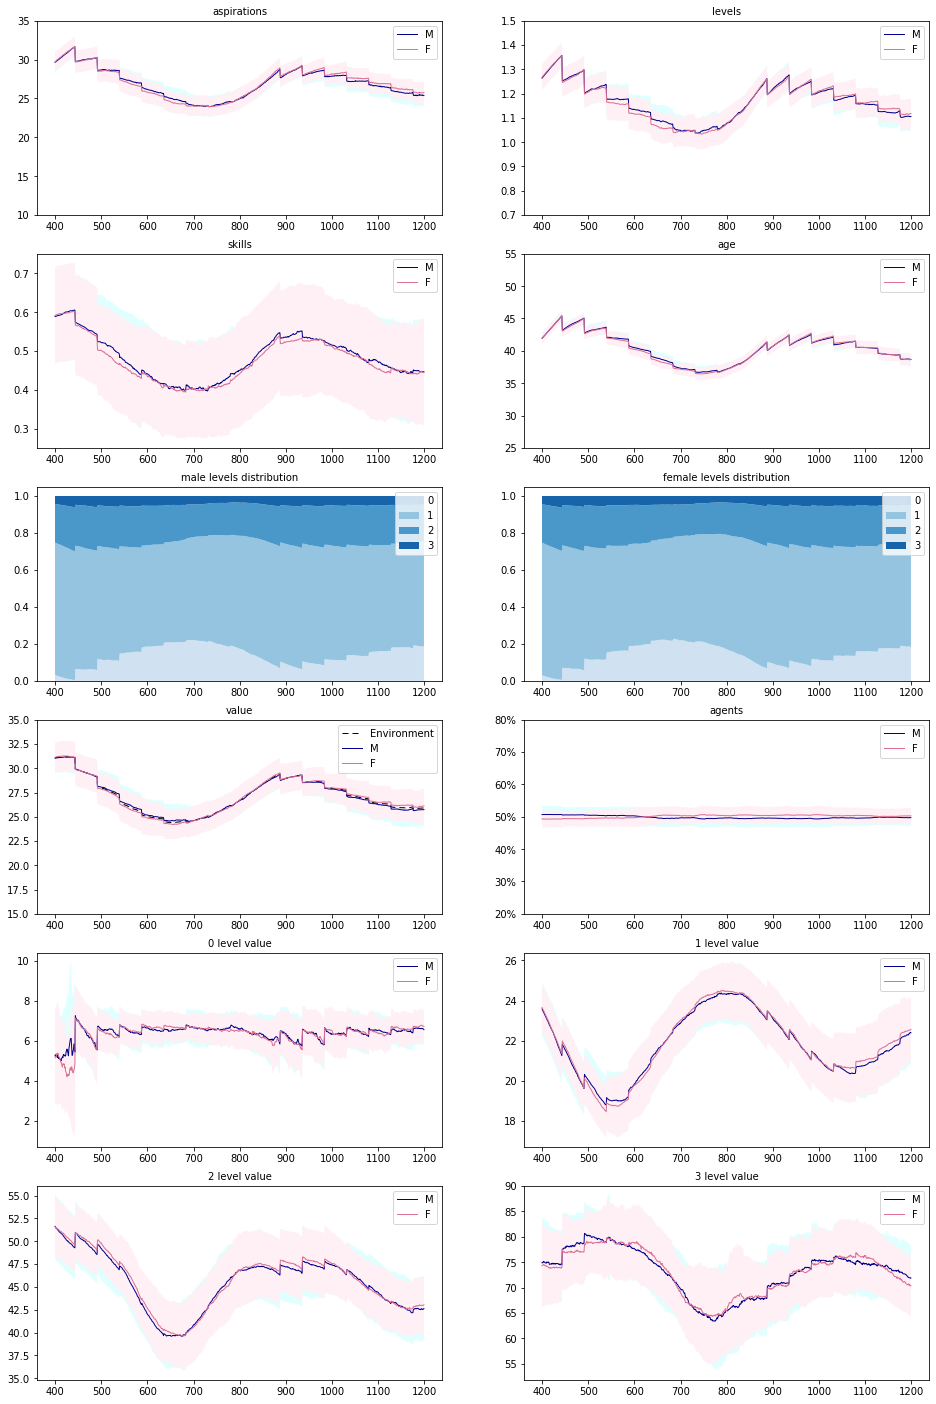

In [10]:
t = np.arange(400, 400+len(mean_asp_M), 1)
fig, axs = plt.subplots(6,2, facecolor='w', figsize=(16,25))
titlefont = {'fontsize': 10, 'fontweight' : 3, 'verticalalignment': 'baseline'}

axs[0,0].set_title('aspirations', **titlefont)
axs[0,0].set_ylim(10,35)
axs[0,0].plot(t, mean_asp_M, c = 'darkblue', lw=1, label = 'M')
axs[0,0].plot(t, mean_asp_F, c = 'palevioletred', lw=1, label = 'F')
axs[0,0].fill_between(t, mean_asp_M+sd_asp_M, mean_asp_M-sd_asp_M, facecolor='lightcyan')
axs[0,0].fill_between(t, mean_asp_F+sd_asp_F, mean_asp_F-sd_asp_F, facecolor='lavenderblush')
axs[0,0].legend(fancybox = True)

axs[0,1].set_title('levels', **titlefont)
axs[0,1].set_ylim(0.7,1.5)
axs[0,1].plot(t, mean_level_M, c = 'darkblue', lw=1, label = 'M')
axs[0,1].plot(t, mean_level_F, c = 'palevioletred', lw=1, label = 'F')
axs[0,1].fill_between(t, mean_level_M+sd_level_M, mean_level_M-sd_level_M, facecolor='lightcyan')
axs[0,1].fill_between(t, mean_level_F+sd_level_F, mean_level_F-sd_level_F, facecolor='lavenderblush')
axs[0,1].legend(fancybox = True)

axs[1,0].set_title('skills', **titlefont)
axs[1,0].plot(t, mean_skills_M, c = 'darkblue', lw=1, label = 'M')
axs[1,0].plot(t, mean_skills_F, c = 'palevioletred', lw=1, label = 'F')
axs[1,0].fill_between(t, mean_skills_M+sd_skills_M, mean_skills_M-sd_skills_M, facecolor='lightcyan')
axs[1,0].fill_between(t, mean_skills_F+sd_skills_F, mean_skills_F-sd_skills_F, facecolor='lavenderblush')
axs[1,0].legend(fancybox = True)

axs[1,1].set_title('age', **titlefont)
axs[1,1].set_ylim(25,55)
axs[1,1].plot(t, mean_age_M, c = 'darkblue', lw=1, label = 'M')
axs[1,1].plot(t, mean_age_F, c = 'palevioletred', lw=1, label = 'F')
axs[1,1].fill_between(t, mean_age_M+sd_age_M, mean_age_M-sd_age_M, facecolor='lightcyan')
axs[1,1].fill_between(t, mean_age_F+sd_age_F, mean_age_F-sd_age_F, facecolor='lavenderblush')
axs[1,1].legend(fancybox = True);

color_map = sns.color_palette("Blues", 4)
axs[2,0].set_title('male levels distribution', **titlefont)
axs[2,0].stackplot(t,get_levels_distribution(master,'male_level_distribution'), labels=range(4),colors=color_map)
axs[2,0].legend(fancybox = True);

axs[2,1].set_title('female levels distribution', **titlefont)
axs[2,1].stackplot(t,get_levels_distribution(master,'female_level_distribution'), labels=range(4),colors=color_map)
axs[2,1].legend(fancybox = True);

axs[3,0].set_title('value', **titlefont)
axs[3,0].set_ylim(15,35)
axs[3,0].plot(t, mean_value, c = 'black', lw=1, label = 'Environment', dashes=(6,4))
axs[3,0].plot(t, mean_value_M, c = 'darkblue', lw=1, label = 'M')
axs[3,0].plot(t, mean_value_F, c = 'palevioletred', lw=1, label = 'F')
axs[3,0].fill_between(t, mean_value+sd_value, mean_value-sd_value, facecolor='whitesmoke')
axs[3,0].fill_between(t, mean_value_M+sd_value_M, mean_value_M-sd_value_M, facecolor='lightcyan')
axs[3,0].fill_between(t, mean_value_F+sd_value_F, mean_value_F-sd_value_F, facecolor='lavenderblush')
axs[3,0].legend(fancybox = True);

axs[3,1].set_title('agents', **titlefont)
axs[3,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[3,1].set_ylim(0.2,0.8)
axs[3,1].plot(t, mean_agents_M, c = 'darkblue', lw=1, label = 'M')
axs[3,1].plot(t, mean_agents_F, c = 'palevioletred', lw=1, label = 'F')
axs[3,1].fill_between(t, mean_agents_M+sd_agents_M, mean_agents_M-sd_agents_M, facecolor='lightcyan')
axs[3,1].fill_between(t, mean_agents_F+sd_agents_F, mean_agents_F-sd_agents_F, facecolor='lavenderblush')
axs[3,1].legend(fancybox = True);

for i in range(4,6):
    for j in range(2):
        lev=j+i*2-8
        axs[i,j].set_title(str(lev)+' level value', **titlefont)
        axs[i,j].plot(t, value_male[lev], c = 'darkblue', lw=1, label = 'M')
        axs[i,j].plot(t, value_female[lev], c = 'palevioletred', lw=1, label = 'F')
        axs[i,j].fill_between(t, value_male[lev]+value_male[lev+4], value_male[lev]-value_male[lev+4], facecolor='lightcyan')
        axs[i,j].fill_between(t, value_female[lev]+value_female[lev+4], value_female[lev]-value_female[lev+4], facecolor='lavenderblush')
        axs[i,j].legend(fancybox = True);

In [11]:
avg_values=[np.mean(mean_asp_M),
    np.mean(mean_asp_F),
    np.mean(mean_level_M),
    np.mean(mean_level_F),
    np.mean(mean_age_M),
    np.mean(mean_age_F),
    np.mean(mean_agents_M),
    np.mean(mean_agents_F),
    np.mean(mean_skills_M),
    np.mean(mean_skills_F),
    np.mean(mean_value),
    np.mean(mean_value_M),
    np.mean(mean_value_F)]

avg_std=[np.mean(sd_asp_M),
    np.mean(sd_asp_F),
    np.mean(sd_level_M),
    np.mean(sd_level_F),
    np.mean(sd_age_M), 
    np.mean(sd_age_F),
    np.mean(sd_agents_M),
    np.mean(sd_agents_F),
    np.mean(sd_skills_M),
    np.mean(sd_skills_F),
    np.mean(sd_value),
    np.mean(sd_value_M),
    np.mean(sd_value_F)]


pd.DataFrame(data=[avg_values,avg_std],index=['mean','std'],columns=['aspiration_M','aspiration_F','level_M','level_F','age_M','age_F','agents_M','agents_F','skills_M','skills_F','value','value_M','value_F']).T

,mean,std
aspiration_M,26.961877,1.328918
aspiration_F,27.012263,1.330745
level_M,1.166739,0.057686
level_F,1.163980,0.059426
age_M,40.458892,0.929060
age_F,40.387031,0.958419
agents_M,0.498446,0.026104
agents_F,0.501554,0.026104
skills_M,0.483319,0.118773
skills_F,0.475236,0.129364


In [12]:
diff_asp=mean_asp_M - mean_asp_F
diff_level=mean_level_M - mean_level_F
diff_age=mean_age_M - mean_age_F
diff_agents=mean_agents_M - mean_agents_F
diff_skills=mean_skills_M - mean_skills_F 
diff_value=mean_value_M - mean_value_F

means=[]
std=[]
t_stat=[]
for i in [diff_asp,diff_level,diff_age,diff_agents,diff_skills,diff_value]:
    means.append(np.mean(i))
    std.append(np.std(i))
    t_stat.append(np.mean(i)/np.std(i))
    
df=pd.DataFrame(data=[means,std,t_stat],index=['average difference','std','T-stat'],columns=['aspiration','level','age','agents','skills','value']).T
df['α 1%']=np.where(abs(df['T-stat'])>2.58,'yes','no')
df

,average difference,std,T-stat,α 1%
aspiration,-0.050386,0.266292,-0.189211,no
level,0.002759,0.010641,0.259275,no
age,0.071861,0.154957,0.463749,no
agents,-0.003108,0.008360,-0.371816,no
skills,0.008083,0.007428,1.088284,no
value,-0.024840,0.233664,-0.106305,no
